This notebook showcases the calculation of enstrophy Probability Distribution Function (PDF) from the Hopkins Turbulence Database. It also demonstrates the calculation of the power spectrar of the excursion set of enstrophy based on the caracteristic function of thresholded sets, for different enstrophy thresholds.

It is necessary, firstly, to execute the commented command on a separate notebook, to enable the parallel execution enviroment, and the following command to allow this notebook to execute in the corresponding enviroment.

In [1]:
#!ipcluster start -n 8 --engines=MPI --profile='mpi' # for parallel run: start the engines using terminal
from ipyparallel import Client
rc = Client(profile='mpi')

Following suit, it is necessary to import the libraries that are necessary to the work to be executed. These include  numpy for the generay array manipulations, pyFFTW to the Fourier Transforms, mpi4py for MPI support, general math, sys and os libraries and pyJHTDB, that provides a python wraper for the C-SOAP interface of the Johs Hopkins Turbulence Databases. We also import some modules that provide basic 3D FFT and histograming functionality build upon numpy and pyFFTW, as a way to streamline the overall process. Those modules, which include FFT3Dfield, IFFT3Dfield and EnergySpectrum, were originaly developed by Dr. Kun Yang.

In [2]:
%%px
# Import the libraries

import os
import sys
import math
import numpy as np
import pyfftw as ft 
from mpi4py import MPI
import matplotlib
import matplotlib.pyplot as plt
import pyJHTDB
from pyJHTDB.dbinfo import isotropic1024coarse
from pyJHTDB import libJHTDB

from fft3d import FFT3Dfield_new
from EnergySpectrum import EnergySpectrum

We first initialize general domain constants, based on the isotropic1024coarse dictionary, which provide information on the isotropic turbulence database.

We then initialize MPI variables, including the communicator, rank and number of process. The typical number of processes is 8, both because it doesn't, usually, overloads the sciserver hardware, but also it is the optimal number of processes to query the database. 

Afterwards, it is necessary to initalize the variables that designate the domain associated with each MPI process. Due to the way that the FFT3D modules were build, we chose to divide the domain in slabs split in the X direction. Also, constants related to wavenumber and chunck size downloads are initialized.

In [3]:
%%px

Nx = isotropic1024coarse['nx']
Ny = isotropic1024coarse['ny']
Nz = isotropic1024coarse['nz']
Lx = isotropic1024coarse['lx']
Ly = isotropic1024coarse['ly']
Lz = isotropic1024coarse['lz']

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
nproc = comm.Get_size()
if(rank==0):
    print("n_proc = "+str(nproc))
    print("rank = "+str(rank))
    
# Computational Domain

nx=Nx//nproc
ny=Ny
nz=Nz
nz_half=nz//2
nek=int(math.sqrt(2.0)/3*Nx)
time = 0.0

chkSz = 32
slabs = nx//chkSz

[stdout:0] 
n_proc = 8
rank = 0


The pre-computed enstrophy is loaded from disk.

In [21]:
%%px

cacheEnstrophyData = False
loadEnstrophyFromCache = True

folder = "/home/idies/workspace/scratch"
filename = "enstrophy-szalay-"+str(rank)+".npz"
file = folder + "/" + filename

if(loadEnstrophyFromCache):
    comm.Barrier(); t1=MPI.Wtime()
    content = np.load(file)
    
    w2 = ft.zeros_aligned((nx,ny,nz), dtype='float32')
    
    #if(int(content['nproc'])!=nproc):
    #    print("Unmatched number of processes. Must first pre-process to adequate number of process")
    w2[:,:,:] = content['w2']
    
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        print("Finished loading")
        sys.stdout.write('Load from disk: {0:.2f} seconds\n'.format(t2-t1))

if(cacheEnstrophyData):
    
    comm.Barrier(); t1=MPI.Wtime()
    np.savez(file,w2=w2,nproc=nproc)
    comm.Barrier(); t2=MPI.Wtime()
    if(rank==0):
        sys.stdout.write('Caching the data: {0:.2f} seconds\n'.format(t2-t1))

[stdout:0] 
Finished loading
Load from disk: 4.65 seconds


It is also computed the average, minimum and maximum values of enstrophy, to be used in the PDF.

In [22]:
%%px
comm.Barrier(); t1=MPI.Wtime()

avgOmega = np.average(w2)
avgOmegaGl=np.zeros(1,dtype='float32')

comm.Reduce([avgOmega,MPI.REAL],[avgOmegaGl,MPI.REAL],op=MPI.SUM)
avgOmega = avgOmegaGl[0]/nproc
avgOmega = comm.bcast(avgOmega, root=0)

##########################

minw2 = w2.min()
maxw2 = w2.max()

minwGl=np.zeros(nproc,dtype='float32')
maxwGl=np.zeros(nproc,dtype='float32')

comm.Allgather([minw2,MPI.REAL],[minwGl,MPI.REAL])
comm.Allgather([maxw2,MPI.REAL],[maxwGl,MPI.REAL])

minw2 = minwGl.min()
maxw2 = maxwGl.max()

comm.Barrier()

if rank==0:
    print("<w^2> : "+str(avgOmega))
    print("min w2/<w^2> : "+str(minw2/avgOmega))
    print("min w2/<w^2> : "+str(maxw2/avgOmega))

comm.Barrier(); t2=MPI.Wtime()
if(rank==0):
    sys.stdout.write('Calculate average enstrophy: {0:.2f} seconds\n'.format(t2-t1))


[stdout:0] 
<w^2> : 491.160614014
min w2/<w^2> : 1.91325866702e-08
min w2/<w^2> : 525.757337839
Calculate average enstrophy: 0.87 seconds


Here is computed the enstrophy PDF on the $[\min \omega^2,20 \langle \omega^2 \rangle]$ range.

In [23]:
%%px

sigma2g = avgOmega
Nbins = 1024
wtemp = w2[w2<=20*sigma2g] 
w2red=np.zeros(Nbins,dtype='int')
lbins = np.logspace(np.log10(minw2/sigma2g),np.log10(20),Nbins)
histred,edgesred = np.histogram(wtemp/sigma2g,lbins)
#hist,edges = np.histogram(w2/sigma2g,10 ** np.linspace(np.log10(m/sigma2g), np.log10(M/sigma2g), Nbins))

In [24]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[w2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()

In [25]:
%%px
left = edgesred[0:(Nbins-1)]
right = edgesred[1:Nbins]
normhist = (histred*(1024**(-3)))/(right-left)

In [26]:
%%px

if rank==0:
    norm = np.sum(normhist*(right-left))

[output:0]

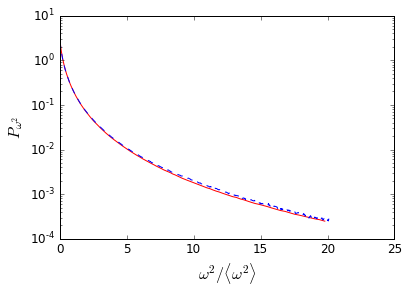

In [27]:
%%px

%matplotlib inline
w2red[-1] = 0
if rank==0:
    w2_bins = np.load('enstrophy_bins.npy')
    w2_pdf = np.load('enstrophy_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')
    #plt.xlim(0,5)
    #plt.ylim(10**(-2),10**(1))

    plt.semilogy((left+right)/2.,normhist/norm,'r',label='Unfiltered')
    plt.semilogy(w2_bins,w2_pdf,'b--')

[output:0]

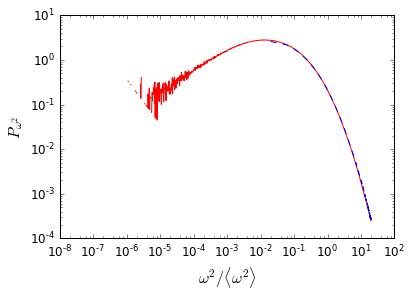

In [28]:
%%px

%matplotlib inline
w2red[-1] = 0
if rank==0:
    w2_bins = np.load('enstrophy_bins.npy')
    w2_pdf = np.load('enstrophy_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')
    #ks=np.linspace(1,101,100)
    #plt.xlabel('$\langle \omega^2\rangle$')
    #plt.ylabel('Bin-count')
    #plt.xlim(0,5)
    #plt.ylim(10**(-2),10**(1))

    plt.loglog((left+right)/2.,normhist/norm,'r',label='Unfiltered')
    plt.loglog(w2_bins,w2_pdf,'b--')
    #plt.loglog((left+right)/2.,normhist/norm,'go',label='Unfiltered')

Here is computed the enstrophy PDF on the $[\min \omega^2,\max \omega^2]$ range.

In [29]:
%%px

sigma2g = avgOmega
Nbins = 1024*8
wtemp = w2[:,:,:] 
w2red=np.zeros(Nbins,dtype='int')
lbins = np.logspace(np.log10(minw2/sigma2g),np.log10(maxw2/sigma2g),Nbins)
histred,edgesred = np.histogram(wtemp/sigma2g,lbins)
#hist,edges = np.histogram(w2/sigma2g,10 ** np.linspace(np.log10(m/sigma2g), np.log10(M/sigma2g), Nbins))

In [30]:
%%px
blocks = Nbins//100
comm.Barrier()
for i in range(blocks):
    comm.Reduce([histred[i*100:(i+1)*100],MPI.INT],[w2red[i*100:(i+1)*100],MPI.INT],op=MPI.SUM)
    comm.Barrier()
    
left = edgesred[0:(Nbins-1)]
right = edgesred[1:Nbins]
normhist = (histred*(1024**(-3)))/(right-left)

if rank==0:
    norm = np.sum(normhist*(right-left))

[output:0]

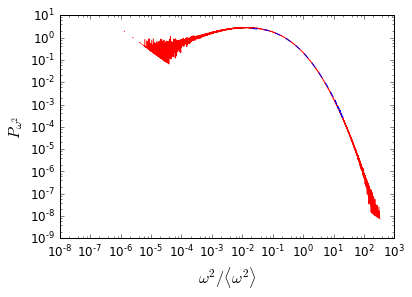

In [31]:
%%px

%matplotlib inline
w2red[-1] = 0
if rank==0:
    w2_bins = np.load('enstrophy_bins.npy')
    w2_pdf = np.load('enstrophy_pdf.npy')
    
    SIZE = 12
    plt.rc('font', size=SIZE)  # controls default text sizes
    plt.rc('axes', titlesize=SIZE+4)  # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE+4)  # fontsize of the x any y labels
    plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE+3)  # legend fontsize
    plt.rc('figure', titlesize=SIZE)  # # size of the figure title
    plt.xlabel(r'$\omega^2/{\langle \omega^2\rangle}$')
    plt.ylabel(r'$P_{\omega^2}$')

    plt.loglog((left+right)/2.,normhist/norm,'r',label='Unfiltered')
    plt.loglog(w2_bins,w2_pdf,'b--')